# How to piano roll

By the end of this notebook, we will be converting images of player piano rolls into MIDI files.

# Humble beginnings

I've got it all figured out.  De-warp (rectify) an image, run some filtering (thresholding and some morphological operators), run connected component analysis and BAM.  Sweet, sweet music.
I should be able to map components directly to notes on the musical staff.  CC analysis yields me the position and dimensions of each component; that's just pitch and duration.  Easy.

Only one big problem: all of this supposes a perfect pinhole camera without that pesky thing known as lens distortion.  Not a huge problem; I can find high-res scans of piano rolls online.  I even have a piece of The Dessert Bar's lighting fixture with which to make my own scans.  I'll have better luck with cleaner data, but I'll need to address distortion and other artifacts if I'm to process images "in the wild".

# Let the experiments begin

In [2]:
# Open Computer Vision (OpenCV) is our friend.  If it ain't broke ...
import cv2

print("You're rocking OpenCV %s" % (cv2.__version__))

You're rocking OpenCV 3.4.2


In [3]:
# 2088.jpg is an image collected "in the wild" by my friend Jeff,
# general manager and sommelier of The Dessert Bar.  We'll use this
# to rough out the warping and filtering processes.
IMGPATH=r'C:\Users\ngvit\Projects\DESSERTBAR\IMG\2088.jpg'
img = cv2.imread(IMGPATH, cv2.IMREAD_GRAYSCALE)

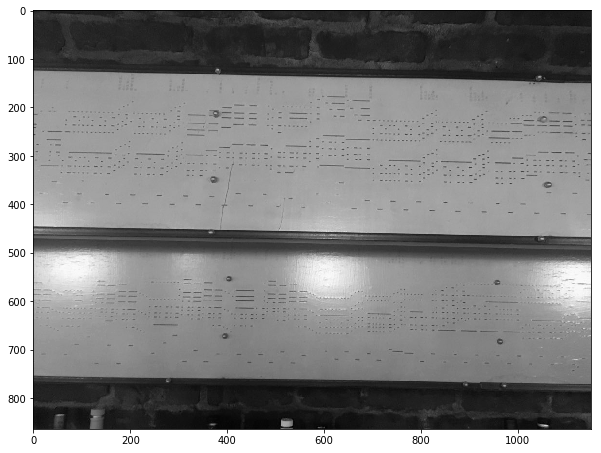

In [6]:
# We'll be using MatPlotLib for our drawing needs.  With a few tweaks
# we're looking pretty, with large inline images.
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Let's get a look at this bad boy ...
plt.imshow(img, cmap='gray')

# Select an AOI from the image

We need to separate the roll from the background and isolate a single section.  Let's ignore distortion for now and use a single 4-point perspective transformation to crop and rectify an area of interest.

Reference: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

In [5]:
# SELECTION 1
pts = np.array([
    [380, 136],
    [1045, 151],
    [1050, 462],
    [365, 450]], dtype="float32")

NameError: name 'np' is not defined

In [ ]:
# SELECTION 2
pts = np.array([
    [403,552],
    [387,757],
    [959,560],
    [970, 767]],dtype="float32")

In [9]:
import numpy as np

def order_points(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left.
    rect = np.zeros((4,2), dtype="float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum.
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference.
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    return rect

In [10]:
def four_point_transform(image, pts):
    # optain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # coordinates or the top-right and top-left coordinates
    widthA = np.linalg.norm(tl - tr)
    widthB = np.linalg.norm(bl - br)
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # coordinates or the top-left and bottom-left coordinates
    heightA = np.linalg.norm(tl - bl)
    heightB = np.linalg.norm(tr - br)
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view".
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0,0],                                   # TL
        [maxWidth - 1, 0],                       # TR
        [maxWidth - 1, maxHeight - 1],           # BR
        [0, maxHeight - 1]], dtype="float32")    # BL
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

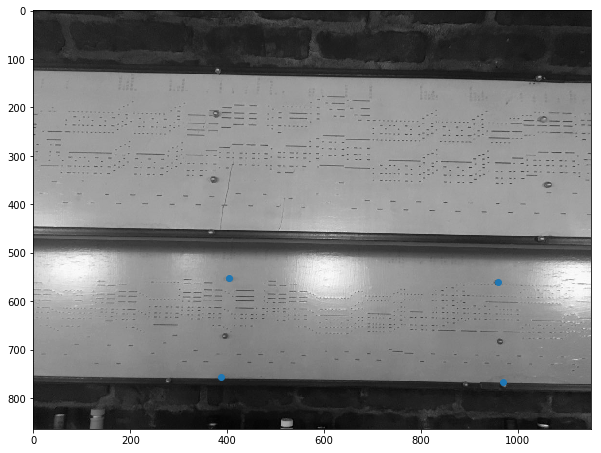

In [200]:
# Let's take a peek...
xs, ys = pts.transpose()
plt.imshow(img, cmap='gray')
plt.plot(xs, ys, 'o')

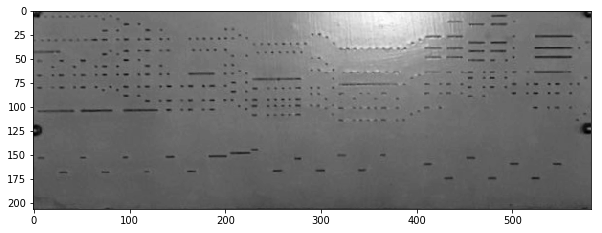

In [201]:
# apply the transformation
original = four_point_transform(img, pts)
warped = cv2.flip(original, 1)
plt.imshow(warped, cmap='gray')

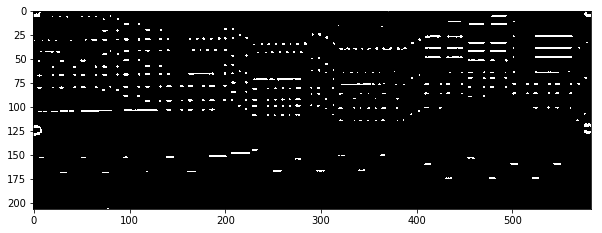

In [208]:
# Apply a threshold function on our image to isolate regions of black
# and white.  the second-to-last parameter is the block size (must be
# odd) and the last parameter is a constant (subtracted from the block
# mean).  The optimal settings were derived experimentally (I guessed).
thresh = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                            cv2.THRESH_BINARY_INV, 9, 18)
# Alternatively, we could use an explicit threshold cutoff.
#retval, thresh = cv2.threshold(warped, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

# Connecting components

We can convert this binary mask into a set of connected components.  As mentioned at the top, the top left x-y coordinate of each component directly maps to the time-pitch coordinates of a note.  The width corresponds to note duration.  Suddenly I've gone from an image to a set of 3D musical coordinates.  Now that's something I can listen to!  Yippee!

I'm realizing that I've sacrificed subpixel accuracy by taking this whole thresh/cc route.  Combined with low resolution imagery, I may run into some trouble.  Here's hoping my initial warp/crop yields as little rotational error as possible.

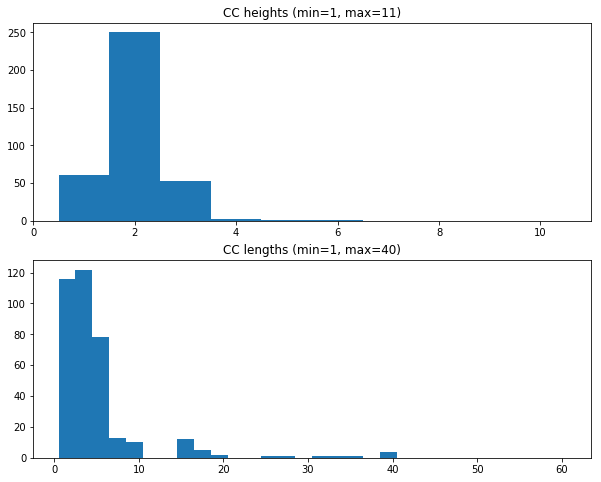

In [209]:
# Compute connected components over image space and store shape statistics.
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

# Whoops; looks like I cropped an edge poorly.  Let's go in with the duct tape...
stats = stats[1:]

# `stats` is a list of (left,top,width,height,area)-tuples.  Let's spare
# a moment to look at the distribution.
heights = [s[3] for s in stats]
lengths = [s[2] for s in stats]
fig, axes = plt.subplots(2,1)
axes[0].set_title('CC heights (min=%d, max=%d)' % (min(heights), max(heights)))
axes[0].hist(heights, bins=np.linspace(0.5, 10.5, 11))
axes[1].set_title('CC lengths (min=%d, max=%d)' % (min(lengths), max(lengths)))
axes[1].hist(lengths, bins=np.linspace(0.5,60.5,31))
plt.show()

Selected 361 of 367 notes
Selected 352 notes


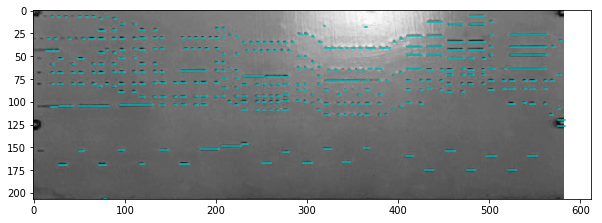

In [210]:
# Clearly there are some outliers; if each note scored in the roll is,
# on average, 2-3 pixels tall, then the 108-pixel component is probably
# gross error (a scratch or something).  Let's enforce some reasonable
# contraints on what CC can be a note.
max_width = 100
max_height = 5
min_y, max_y = 5, 375 # margins (there's some riff-raff around the image edges)
notes = []
for s in stats:
    l,t,w,h,a = s # unpack
    if w > max_width or h > max_height: continue
    if t < min_y or t > max_y: continue
    # Notes are in R3 as <TIME><PITCH><DURATION>
    time, pitch, dur = l, t+h/2, w
    notes.append([time,pitch,dur])
print('Selected %d of %d notes' % (len(notes), len(stats)))

# Additionally, we're going to crop to a small section of notes.
#t_min, t_max = 330, 575
t_min, t_max = 10, 700
notes = [(t,p,d) for t,p,d in notes if t > t_min and t+d < t_max]
print('Selected %d notes' % (len(notes)))

# Always show your work
plt.imshow(warped, cmap='gray')
for n in notes:
    t,p,d = n
    plt.plot([t,t+d],[p,p], color='c')

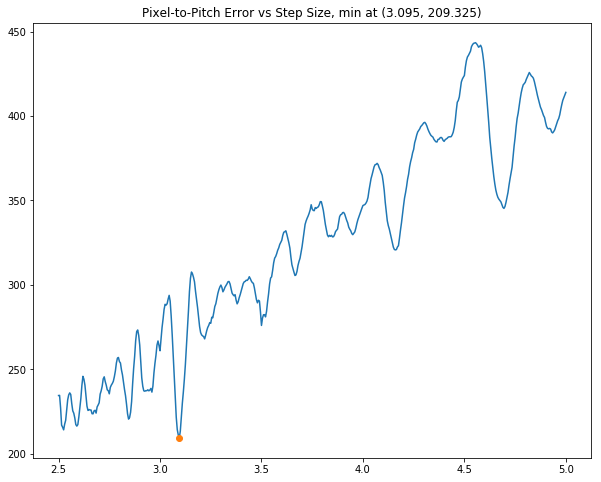

In [211]:
# We now need a pixel-to-pitch mapping function.  We're effectively binning everything.
# We need an offset and a step size.  Let's evaluate a few and compute an error measure
# for each note (distance to bin center).  The best fit should have a low error.

ps = [p for t,p,d in notes]
offset = min(ps) # assuming lower is higher on the staff...

#step_sizes = np.linspace(1.5,2.0,201)
step_sizes = np.linspace(2.5,5.0,501)
errors = []
for s in step_sizes:
    error = 0
    for t,p,d in notes:
        p0 = p - offset
        q = s * round(p0 / s)
        error = error + abs(p0-q)
    errors.append(error)
    
step = step_sizes[np.argmin(errors)]

plt.title("Pixel-to-Pitch Error vs Step Size, min at (%0.3f, %0.3f)"
          % (step, np.min(errors)))
plt.plot(step_sizes, errors)
plt.plot(step, np.min(errors), marker='o')

In [212]:
# Apply our pixel-to-pitch function
t0 = min(t for t,p,d in notes)
pix2pit = lambda x: round((x - offset) / step)
t2ktime = lambda x: (x - t0)
final_notes = [(t2ktime(t),pix2pit(p),d) for t,p,d in notes]
p_max = max(p for t,p,d in final_notes)
p_max

65.0

In [214]:
# AND ITS MAGIC TIME

# or at least, more magic than LAST time ...
from midiutil import MIDIFile

track    = 0
channel  = 0
tempo    = 100  # In BPM
volume   = 100  # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                      # automatically)
MyMIDI.addTempo(track, time, tempo)

pix_per_beat = 20.0

MIDI_MIN=21 # A0
MIDI_MAX=108 # C8
KEYDOWN=9
for note in final_notes:
    t,p,d = note
    time = t / pix_per_beat
    pitch = MIDI_MAX - p - KEYDOWN
    dur = d / pix_per_beat
    
    MyMIDI.addNote(track, channel, int(pitch), time, dur, volume)

with open("major-flub2-flip.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [ ]:
# REALLY LAME MIDI-MAPPING
# enforce some reasonable limitations on width, length
inliers = []
for idx, s in enumerate(stats):
    l,t,w,h,a = s
    if w < 200 and h < 8 and t > 10 and l > 10:
        inliers.append(idx)
print(len(stats), len(inliers))
notes = np.take(stats, inliers, axis=0)
min_width = np.median([n[2] for n in notes])
min_width # 8; we will divide note by 8 to get beat duration
min_top = np.min([n[1] for n in notes])
max_top = np.max([n[1] for n in notes])
min_sound = np.min([n[0] for n in notes])
max_sound = np.max([n[0] + n[2] for n in notes])
print(min_top, max_top)
print(min_sound, max_sound) # 22, 1370
(max_top - min_top) / 4 # 137 (PERFECT)

# Correcting the perspective transformation

In [46]:
from matplotlib import pyplot as plt

In [47]:
lines.shape

(47, 4)

In [70]:
slope = lambda x1,y1,x2,y2: (y2-y1)/(x2-x1)
y = [ min(line[1], line[3]) for idx,line in enumerate(lines) if abs(slope(*line)) < 1.0 ]
ymin = min(y)
yn = y - ymin
#yn

# 10 = a * x
# 15 = b * x
# 20 = c * x
# 25 = d * x
np.gcd.reduce(yn)
np.sort(yn)
np.diff(np.sort(yn))

array([23, 13,  1,  0,  2,  0,  7,  1,  0,  1,  0,  0,  0,  1, 14,  0,  1,
        1, 10,  3,  1,  3,  6,  0,  1,  0, 15,  0,  1, 13,  3,  9,  0,  0,
        0,  1,  0, 15,  1, 10,  1,  1,  1, 11,  1], dtype=int32)

array([     0,      0,   1370,    628, 839750], dtype=int32)

In [215]:
from midiutil import MIDIFile

degrees  = [60, 62, 64, 65, 67, 69, 71, 72]  # MIDI note number
track    = 0
channel  = 0
time     = 0    # In beats
duration = 1    # In beats
tempo    = 240   # In BPM
volume   = 100  # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                      # automatically)
MyMIDI.addTempo(track, time, tempo)

for note in notes:
    left,top,width,height,area = note
    dur = width / 16.0
    pitch = (137 - ((top - min_top) / 4)) / 2.0 + 21
    time = (left - min_sound) / 16.0
    
    #print(pitch, time, dur, volume)
    MyMIDI.addNote(track, channel, int(pitch), time, dur, volume)

with open("major-scale.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [230]:
# REALLY LAME MIDI-MAPPING
# enforce some reasonable limitations on width, length
inliers = []
for idx, s in enumerate(stats):
    l,t,w,h,a = s
    if w < 200 and h < 8 and t > 10 and l > 10:
        if l > 655 and l < 855:
            inliers.append(idx)
print(len(stats), len(inliers))
notes = np.take(stats, inliers, axis=0)
min_width = np.median([n[2] for n in notes])
min_width # 8; we will divide note by 8 to get beat duration
min_top = np.min([n[1] for n in notes])
max_top = np.max([n[1] for n in notes])
min_sound = np.min([n[0] for n in notes])
max_sound = np.max([n[0] + n[2] for n in notes])
print(min_top, max_top)
print(min_sound, max_sound) # 22, 1370
(max_top - min_top) / 4 # 137 (PERFECT)

430 69
170 537
660 868


91.75

In [254]:
ys = np.sort([ n[1] + (n[3] / 2.0) for n in notes ])
deltaY = np.diff(ys)
#deltaY / 20 * 3
(ys - ys[0]) * 2 / 20
#(ys - min_top) / 20.0 * 3

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.05,  0.05,  0.05,
        0.05,  0.05,  2.05,  2.05,  2.05,  2.1 ,  2.1 ,  3.4 ,  3.4 ,
        3.45,  3.45,  5.45,  5.45,  5.45,  5.45,  5.5 ,  5.5 ,  5.5 ,
        5.5 ,  5.5 ,  8.15,  8.2 ,  8.2 ,  8.25,  8.25,  8.25,  8.25,
        8.25,  8.25,  8.25,  8.25, 16.55, 18.55, 18.55, 18.55, 18.6 ,
       19.95, 19.95, 20.  , 20.  , 21.95, 21.95, 22.  , 22.  , 22.05,
       22.05, 22.05, 22.05, 24.75, 24.8 , 24.8 , 24.8 , 24.8 , 24.8 ,
       24.85, 24.85, 33.15, 33.2 , 36.55, 36.65])

In [256]:
from midiutil import MIDIFile

degrees  = [60, 62, 64, 65, 67, 69, 71, 72]  # MIDI note number
track    = 0
channel  = 0
time     = 0    # In beats
duration = 1    # In beats
tempo    = 240   # In BPM
volume   = 100  # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                      # automatically)
MyMIDI.addTempo(track, time, tempo)

for note in notes:
    left,top,width,height,area = note
    dur = width / 16.0
    pitch = 90 - np.round(((top - min_top) / 20 * 3))
    time = (left - min_sound) / 16.0
    
    #print(pitch, time, dur, volume)
    MyMIDI.addNote(track, channel, int(pitch), time, dur, volume)

with open("major-scale.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [26]:
rho = 0.5 # distance resolution in pixels of the Hough grid
theta = np.pi / 180 # angular resolution in radians of the Hough grid
threshold = 10 # minimum number of votes
min_line_length = 40
max_line_gap = 15

lines = cv2.HoughLinesP(thresh, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
lines = lines.squeeze(1)

True

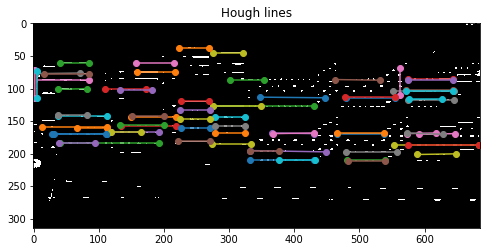

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
ax.imshow(thresh, cmap='gray', shape=(100,10))
for line in lines:
    x1,y1,x2,y2 = line
    ax.plot([x1,x2],[y1,y2], marker='o')
ax.set_title("Hough lines")
plt.savefig("DESSERTBAR_LINES.jpg")
cv2.imwrite("THRESH.jpg", thresh)
cv2.imwrite("WARPED.jpg", warped)